### Get Data

In [75]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "http://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [76]:
fetch_housing_data()

In [77]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [78]:
housing = load_housing_data()
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

### Quick look into Data

In [79]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [80]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [81]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

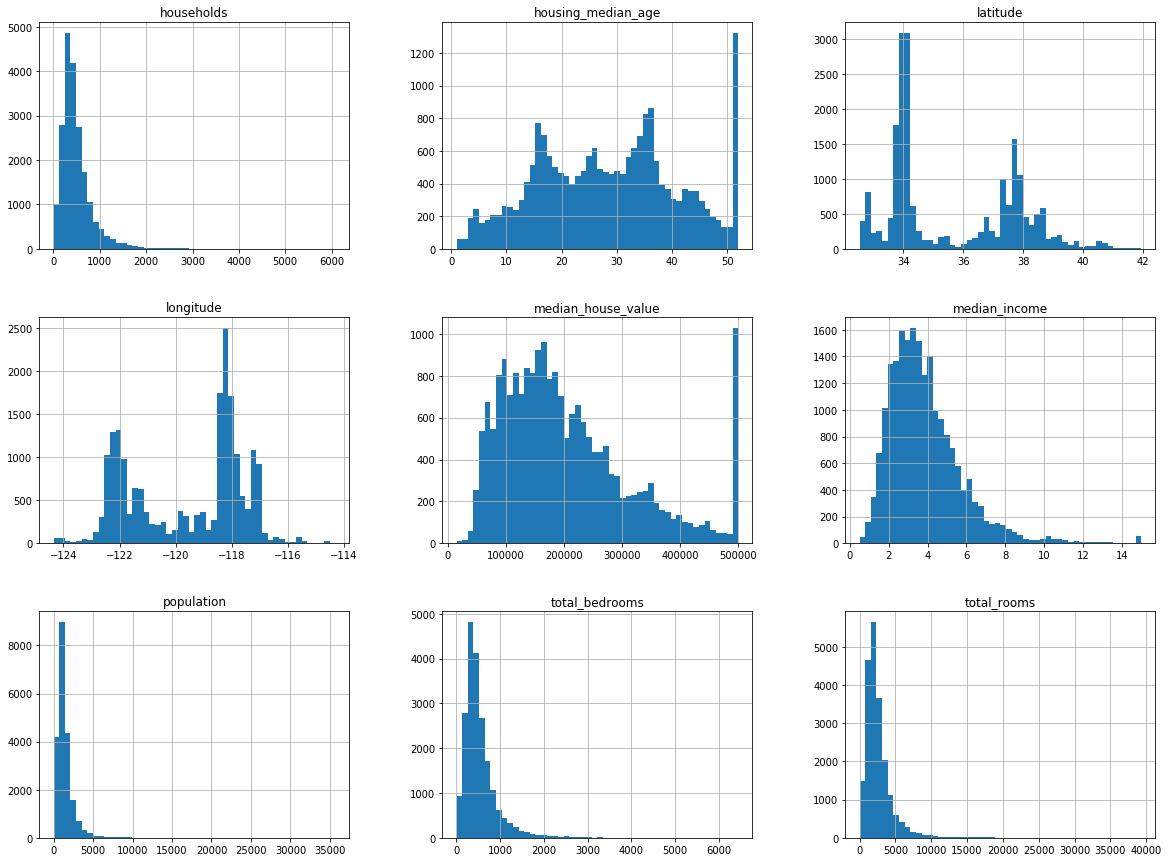

In [82]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

### Put test set aside before getting more insight

In [83]:
import numpy as np

# this function always creates new testset and even if we set seed, it will still break once data gets updated
def split_train_test(data, test_ratio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [84]:
import hashlib

# these two functions split by last digits hash digest (which can be 1-256)
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [85]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [86]:
from sklearn.model_selection import train_test_split

#if we want totally random data thats same every time
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [87]:
# if we want representative sample
housing["income_cat"] = np.ceil(housing["median_income"]/ 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [88]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [89]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [90]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

### Discover and visualize the Data

In [91]:
housing = strat_train_set.copy()

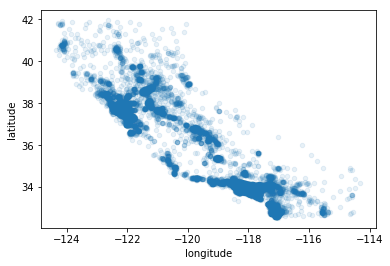

In [92]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

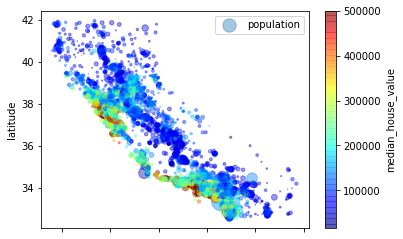

In [93]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"]/100, label="population", c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,)

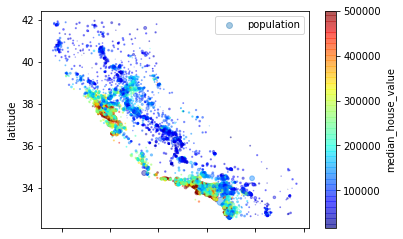

In [94]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"]/500, label="population", c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,)

In [95]:
corr_matrix = housing.corr()

In [96]:
corr_matrix.median_house_value.sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

In [97]:
from pandas.plotting import scatter_matrix

In [98]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f78d6bfef98>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f78d6b28128>]], dtype=object)

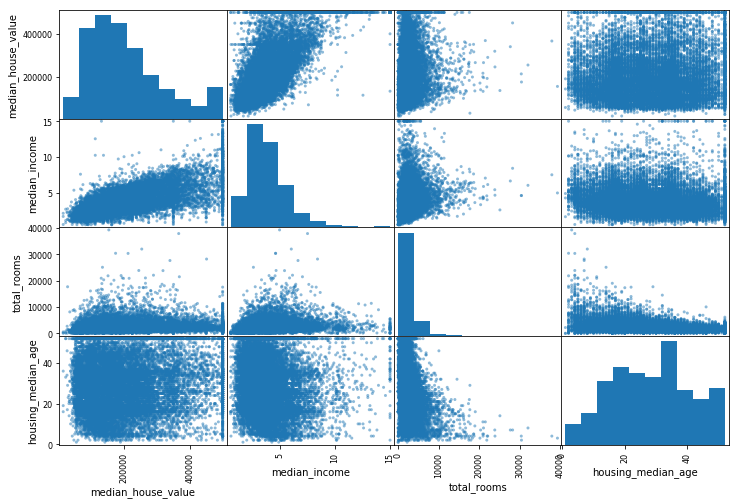

In [99]:
scatter_matrix(housing[attributes], figsize=(12,8))

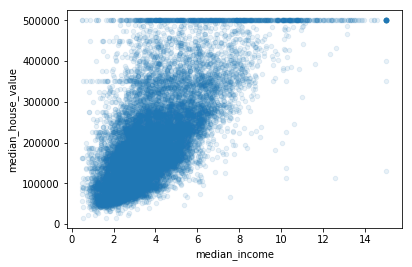

In [100]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

In [101]:
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17606    -121.89     37.29                38.0       1568.0           351.0   
18632    -121.93     37.05                14.0        679.0           108.0   
14650    -117.20     32.77                31.0       1952.0           471.0   
3230     -119.61     36.31                25.0       1847.0           371.0   
3555     -118.59     34.23                17.0       6592.0          1525.0   

       population  households  median_income  median_house_value  \
17606       710.0       339.0         2.7042            286600.0   
18632       306.0       113.0         6.4214            340600.0   
14650       936.0       462.0         2.8621            196900.0   
3230       1460.0       353.0         1.8839             46300.0   
3555       4459.0      1463.0         3.0347            254500.0   

      ocean_proximity  
17606       <1H OCEAN  
18632       <1H OCEAN  
14650      NEAR OCEAN  
3230           INLAND  
3555        <1H OCEAN

In [108]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]

In [103]:
housing["bedrooms_per_room"] = housing.total_bedrooms/housing.total_rooms

In [104]:
housing["population_per_household"] = housing.population/housing.households

In [105]:
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17606    -121.89     37.29                38.0       1568.0           351.0   
18632    -121.93     37.05                14.0        679.0           108.0   
14650    -117.20     32.77                31.0       1952.0           471.0   
3230     -119.61     36.31                25.0       1847.0           371.0   
3555     -118.59     34.23                17.0       6592.0          1525.0   

       population  households  median_income  median_house_value  \
17606       710.0       339.0         2.7042            286600.0   
18632       306.0       113.0         6.4214            340600.0   
14650       936.0       462.0         2.8621            196900.0   
3230       1460.0       353.0         1.8839             46300.0   
3555       4459.0      1463.0         3.0347            254500.0   

      ocean_proximity  rooms_per_household  bedrooms_per_room  \
17606       <1H OCEAN             4.625369           0.223852   
18632       <1H OCEAN             6.008850           0.159057   
14650      NEAR OCEAN             4.225108           0.241291   
3230           INLAND             5.232295           0.200866   
3555        <1H OCEAN             4.505810           0.231341   

       population_per_household  
17606                  2.094395  
18632                  2.707965  
14650                  2.025974  
3230                   4.135977  
3555                   3.047847

In [109]:
corr_matrix = housing.corr()

In [110]:
corr_matrix.median_house_value.sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

### Prepare data for machine learning

In [111]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_lables = strat_train_set["median_house_value"].copy()

In [114]:
# data cleaning for missing features
# instead of using housing.total_bedrooms.fillna(median) we can use sklearn Imputer
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")
# median can only be calculated on numerical values so create a copy of dataframe without ocean_proximity
housing_num = housing.drop("ocean_proximity", axis = 1)

imputer.fit(housing_num)
imputer.statistics_

array([ -118.51  ,    34.26  ,    29.    ,  2119.5   ,   433.    ,
        1164.    ,   408.    ,     3.5409])

In [121]:
# now use "trained" imputer to transform training set
X = imputer.transform(housing_num)

In [125]:
# result of imputer is numpy array, so if we want we can transform it to dataframe 
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [126]:
housing_tr.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -121.89     37.29                38.0       1568.0           351.0   
1    -121.93     37.05                14.0        679.0           108.0   
2    -117.20     32.77                31.0       1952.0           471.0   
3    -119.61     36.31                25.0       1847.0           371.0   
4    -118.59     34.23                17.0       6592.0          1525.0   

   population  households  median_income  
0       710.0       339.0         2.7042  
1       306.0       113.0         6.4214  
2       936.0       462.0         2.8621  
3      1460.0       353.0         1.8839  
4      4459.0      1463.0         3.0347